# License Notice

Copyright (c) 2024 Warren Bebbington

This notebook is part of the simple-glucose-analysis project and is licensed under the MIT License. For the full license text, please see the LICENSE file in the project's root directory.

# My Authentic Personal Glucose Control Analysis Project

## Introduction

This project presents an analysis of my actual continuous glucose monitoring (CGM) data as a person living with Type 1 Diabetes. The dataset spans a 15 month period and includes my genuine glucose readings, insulin doses, and carbohydrate intake information.

**Important Note:** While this is my real, unmodified data, I've taken steps to protect my privacy:

1. The specific date range of the data collection has been anonymized.
2. This dataset is not from the current time period, which adds a layer of privacy protection.

## Project Objectives

1. Showcase my data analysis skills using Python, particularly with time-series health data.
2. Demonstrate my proficiency in data cleaning, preprocessing, and visualization techniques.
3. Apply statistical analysis methods to derive insights from my glucose monitoring data.
4. Explore authentic patterns and relationships in my diabetes management data.
5. Present my findings in a clear, visually appealing manner.

## Data Description

My dataset includes:
- Actual glucose readings (mmol/L) at 5-minute intervals
- Real insulin doses (units)
- Relativley accurate carbohydrate intake (grams)

## Ethical Considerations and Data Usage

As a person with Type 1 Diabetes, I understand the significance of this data. I want to emphasize a few key points:

1. Privacy: While the data is genuine, the anonymized date range protects my privacy.
2. Not Current Data: This dataset is from a past period, not representing my current diabetes management.
3. Educational Purpose: This project is intended to demonstrate data analysis skills and general diabetes management insights.
4. Medical Disclaimer: Despite being real data, the insights generated here should not be considered medical advice. As always, I will only consider changes to my diabetes management in consultation with healthcare professionals.

## Intended Use of Insights

The insights derived from this analysis are primarily for:
1. Demonstrating my data analysis capabilities.
2. Showcasing the potential of data analysis in diabetes management.
3. Personal reflection on past diabetes management strategies.

Any application of these insights to actual diabetes management would only be done under the guidance of medical professionals.

## Tools and Libraries Used

- Python 3.x
- Pandas for data manipulation
- Matplotlib and Seaborn for data visualization
- Scipy for statistical analysis
- Statsmodels for time series analysis
- XDrip+(Android) for recieving and storing of CGM data, insulin doses and carbohydrate intake
- Libre 2 Glucose Sensor and LibreLink(Android) app to initialise sensors

Through this project, I aim to demonstrate not only my technical skills in data analysis but also provide authentic insights into the complexities of diabetes management. Let's explore my real-world glucose monitoring data and uncover valuable patterns and trends!

## 1. Data Overview and Preprocessing

In this initial stage, I'll prepare my data for analysis. The datasets used were obtained by completing a backup from Xdrip+ on an android device, connected to Libre 2 sensors for 14 days at a time(Instructions in README.md). Each new Libre 2 should have been initiated 1 hour prior to the previous expiring, which should negate warm-up gaps in the data. This datasets include CGM readings, insulin doses, and carbohydrate intake data. We will start by cleaning the data to remove any errors or inconsistencies, and creating useful time-based features to aid my analysis.

### Import Libraries and Load Data

In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [328]:
# Load my data
df = pd.read_csv('data/sample_data.csv', index_col=0)

## Useful columns

We will create some extra columns that will be useful later on in this analysis.

- **is_weekend**: This will be a boolean column represented by a 1 if day is Saturday or Sunday
- **intervals_since_carbs**: This will be an interger representing the number of 5-minute intervals since last carbs were ate. This will be used for finding corrective bolus doses vs late meal bolus doses.
- **no_treatments_for_4hours**: This will be used in determining which four hour periods can be assesed for isf calculations, only times where no extra carbs or insulin adjust the rate of change.
- **hour_change**: This will represent the difference between the current glucose level and the previous hour used to determine if glucose is stable enough to consider for different calculations.
- **is_stable**: - This will be used to see if the previous hours glucose change is <= 0.5 mmol and >= -0.5 mmol.
- **is_moderate**: This will be used to see if the previous hours glucose change is <=1.0 mmol and >= -1.0 mmol

In [329]:
# Create boolean for is weekend
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']) # Can be used to distinguish between work and no work days


# Create a new column for intervals since last carbs > 0.0
def count_intervals_since_carbs(carb_value):
    return 0 if carb_value > 0.0 else 1  # Reset count if carbs > 0.0

# Apply the function to create a helper column
df['reset'] = df['carbs'].apply(count_intervals_since_carbs)

# Calculate the cumulative sum of the resets to create the intervals
df['intervals_since_carbs'] = df['reset'].cumsum() - df['reset'].cumsum().where(df['reset'] == 0).ffill().fillna(0).astype(int)

# Drop the helper column if not needed
df.drop(columns=['reset'], inplace=True)


# Create the new column and initialize it with True
df['no_treatments_for_4hours'] = True

# Iterate through each row
for index in range(len(df) - 37):  # Exclude the last 36 rows to avoid index error
    # Check the next 48 rows for any values in 'carbs' or 'bolus' greater than 0
    if any(df['carbs'].iloc[index + 1:index + 49] > 0) or any(df['bolus'].iloc[index + 1:index + 49] > 0):
        df.at[index, 'no_treatments_for_4hours'] = False  # Set to False if treatments are found

        
# Calculate the change over the past hour
df['hour_change'] = df['glucose'].shift(-12) - df['glucose']

# Define stability conditions
stable_condition = (df['hour_change'] >= -0.5) & (df['hour_change'] <= 0.5)
moderate_condition = (df['hour_change'] >= -1.0) & (df['hour_change'] <= 1.0)

# Create a new column to indicate stability
df['is_stable'] = stable_condition  # True if stable
df['is_moderate'] = stable_condition | moderate_condition  # True if stable or moderately stable


In [330]:
df

,glucose,carbs,basal,bolus,day_of_week,time,is_weekend,intervals_since_carbs,no_treatments_for_4hours,hour_change,is_stable,is_moderate
0,7.440193,0.0,0.0,0.0,Saturday,22:30:00,True,1,False,-2.637623,False,False
1,6.932764,0.0,0.0,0.0,Saturday,22:35:00,True,2,False,-2.406517,False,False
2,6.711706,0.0,0.0,0.0,Saturday,22:40:00,True,3,False,-2.436661,False,False
3,6.377608,0.0,0.0,0.0,Saturday,22:45:00,True,4,False,-2.223139,False,False
4,6.043509,0.0,0.0,0.0,Saturday,22:50:00,True,5,False,-1.537357,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
138286,4.303597,0.0,0.0,0.0,Saturday,11:40:00,True,17,True,NaN,False,False
138287,4.205091,0.0,0.0,0.0,Saturday,11:45:00,True,18,True,NaN,False,False
138288,4.202853,0.0,0.0,0.0,Saturday,11:50:00,True,19,True,NaN,False,False
138289,4.200614,0.0,0.0,0.0,Saturday,11:55:00,True,20,True,NaN,False,False


In [331]:
df.describe()

,glucose,carbs,basal,bolus,intervals_since_carbs,hour_change
count,138291.000000,138291.000000,138291.000000,138291.000000,138291.000000,138279.000000
mean,6.591852,0.668589,0.044725,0.109840,38.263589,-0.000081
std,3.003750,5.264467,2.792173,0.734048,37.338442,2.730271
min,-2.052434,0.000000,0.000000,0.000000,0.000000,-18.498823
25%,4.535287,0.000000,0.000000,0.000000,10.000000,-1.373158
50%,6.117546,0.000000,0.000000,0.000000,26.000000,-0.020567
75%,8.011572,0.000000,0.000000,0.000000,55.000000,1.412967
max,22.308520,140.000000,1000.000000,16.000000,294.000000,22.308520


## 2. Overall Glucose Control Metrics
Here, I'll calculate key metrics that give me a broad view of my glucose control. This includes analyzing my Time in Range (TIR), average glucose levels, and the frequency of high and low glucose events. These metrics will provide me with a baseline understanding of my overall glucose management.

### Time in Range Analysis

In [332]:
def calculate_tir(data):
    total_readings = len(data)
    in_range = ((data >= 3.9) & (data <= 10.0)).sum()
    below_range = (data < 3.9).sum()
    above_range = (data > 10.0).sum()
    
    return {
        'in_range': in_range / total_readings * 100,
        'below_range': below_range / total_readings * 100,
        'above_range': above_range / total_readings * 100
    }
    
tir = calculate_tir(df['glucose'])
print("Time in Range Metrics:")
print(f"In Range (3.9-10.0 mmol/L): {tir['in_range']:.2f}%")
print(f"Below Range (< 3.9 mmol/L): {tir['below_range']:.2f}%")
print(f"Above Range (> 10.0 mmol/L): {tir['above_range']:.2f}%")

Time in Range Metrics:
In Range (3.9-10.0 mmol/L): 72.67%
Below Range (< 3.9 mmol/L): 16.04%
Above Range (> 10.0 mmol/L): 11.29%


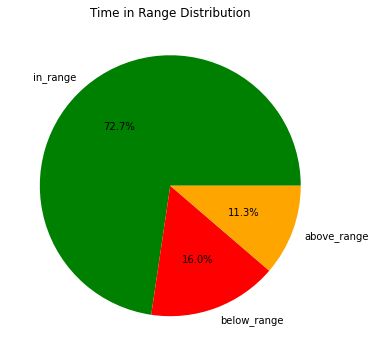

In [333]:
# Define colors for each section: green for in-range, red for below, yellow for above
colors = ['green', 'red', 'orange']

# Visualize Time in Range
plt.figure(figsize=(10, 6))
plt.pie(tir.values(), labels=tir.keys(), autopct='%1.1f%%', colors=colors)
plt.title('Time in Range Distribution')
plt.show()

### Time in Range Analysis:
- The pie chart shows the distribution of glucose readings across different ranges.
- I can see I was only in range for 72.7% of the time in this period, I am advised to aim for >75% time-in-range and <1% of time should ideally be spent below range. I was clearly missing these target for time below range, but almost at 75% for time in range.
- Time below range factors should be investigated as a major part of this analysis.
- This gives us an overall picture of glycemic control, but we should also look at other metrics.

### Glycemic Variability Metrics

In [334]:
mean_glucose = df['glucose'].mean()
median_glucose = df['glucose'].median()
std_glucose = df['glucose'].std()
cv_glucose = (std_glucose / mean_glucose) * 100

print(f"Mean Glucose: {mean_glucose:.2f} mmol/L")
print(f"Median Glucose: {median_glucose:.2f} mmol/L")
print(f"Standard Deviation: {std_glucose:.2f} mmol/L")
print(f"Coefficient of Variation: {cv_glucose:.2f}%")

Mean Glucose: 6.59 mmol/L
Median Glucose: 6.12 mmol/L
Standard Deviation: 3.00 mmol/L
Coefficient of Variation: 45.57%


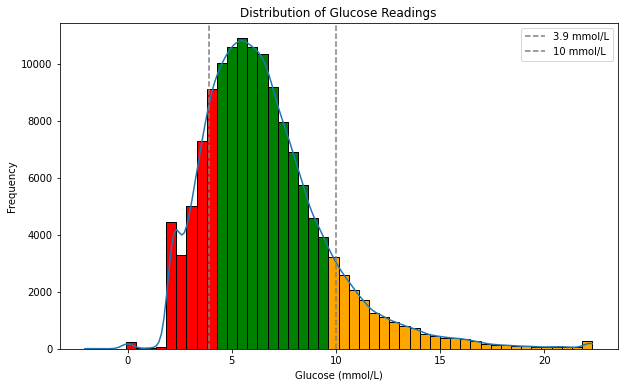

In [335]:
# Visualize glucose distribution
plt.figure(figsize=(10, 6))

# Create a histogram
hist = sns.histplot(df['glucose'], bins=50, kde=True)

# Add vertical gridlines at 3.9 and 10
plt.axvline(x=3.9, color='grey', linestyle='--', label='3.9 mmol/L')
plt.axvline(x=10.0, color='grey', linestyle='--', label='10 mmol/L')

# Color bars based on glucose levels
for patch in hist.patches:
    if patch.get_x() < 3.9:
        patch.set_facecolor('red')  # Below 3.9 mmol/L
    elif 3.9 <= patch.get_x() + patch.get_width() <= 10:
        patch.set_facecolor('green')  # Between 3.9 and 10 mmol/L
    else:
        patch.set_facecolor('orange')  # Above 10 mmol/L

# Title and labels
plt.title('Distribution of Glucose Readings')
plt.xlabel('Glucose (mmol/L)')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show plot
plt.show()

### Glycemic Variability Analysis:
- The histogram shows the distribution of glucose readings.
- **Mean glucose is 6.59 mmol**, which is within the defined range.
- The **standard deviation of 3.00 mmol** indicates moderatley-high variability.
- **Coefficient of Variation (CV) of 45.57%** suggests very high variation (Defined as high when >36%).
- The distribution shows a **longer tail on the right side** suggesting that high values, though rarely, can be very high.
- The distribution also shows a **small count at 0 mmol**, which is obviously a sensor error and is not physiologically possible, these values will be ignored.
- The distribution also shows a **smaller tail on the low side, but a much higher frequency**. Episodes of low blood glucose seem to occur much more and are more persistent than times of high glucose. 

Finding patterns and insights to help negate low blood glucoses episode should be paramount within this analysis.

## 3. Insulin Effectiveness Analysis
This section focuses on how well my insulin is working. I'll calculate my Insulin Sensitivity Factor (ISF) and Insulin-to-Carb Ratio (ICR), and examine how these might vary throughout the day. This information is crucial for optimizing my insulin dosing strategy.

### Insulin Sensitivity Factor (ISF) Calculation

In [338]:
# Count occurrences where all conditions for ISF calculation are met
count_conditions_met = df[
    (df['is_moderate']) & 
    (df['no_treatments_for_4hours']) & 
    (df['intervals_since_carbs'] > 24) &
    (df['bolus'] > 0)
].shape[0]  # Alternatively, you can use len(df[...]).

print(f"Occurrences where conditions are met: {count_conditions_met - 48}")

Occurrences where conditions are met: 27


In [339]:
def calculate_isf(data):
    
    corrections = data[ (data['is_moderate']) & data['no_treatments_for_4hours'] & (data['intervals_since_carbs'] > 24) & (data['bolus'] > 0)].copy() # >48 more than 4 hour
    
    # Calculate glucose change over 4 hours
    corrections['glucose_change'] = corrections['glucose'] - corrections['glucose'].shift(-48)
    
     # Drop the last 48 rows just before final calculations
    corrections = corrections.iloc[:-48]
    
    # Calculate isf
    corrections['isf'] = corrections['glucose_change'] / corrections['bolus']
    
    return corrections['isf'].mean(), corrections['isf']

isf, isf_data = calculate_isf(df)
print(f"Average Insulin Sensitivity Factor: {isf:.2f} mmol/L per unit")

Average Insulin Sensitivity Factor: 0.11 mmol/L per unit


# Insulin Sensitivity Factor (ISF) Analysis

## Results
- Calculated Average Insulin Sensitivity Factor: 0.11 mmol/L per unit
- My estimated ISF: 2.0 mmol/L per unit
- Number of data points used in calculation: 11

## Interpretation
The calculated ISF of 0.11 mmol/L per unit is significantly lower than my estimated ISF of 2.0 mmol/L per unit, which I find to be pretty accurate in practice. This discrepancy is likely due to the scarcity of data points and the strict filtering conditions I've applied.

## Data Filtering
For this calculation, I used the following criteria:
- Bolus insulin > 0
- No carbs in the previous 2 hours
- No insulin or carbs in the following 4 hours
- Blood glucose changed < 1.0 mmol in the previous hour

These strict conditions, while intended to isolate "clean" correction doses, have resulted in very few data points (only 11) being used for the calculation.

## Considerations
1. **Data Scarcity**: With only 11 data points meeting my criteria, the calculated ISF is likely not representative of my true insulin sensitivity. I need to find ways to gather more relevant data points.

2. **Filtering Criteria**: My current filtering might be too strict, excluding many potentially useful data points. I might need to adjust these criteria to balance between data quality and quantity.

3. **Meal and Snack Timing**: The low number of qualifying events might be due to my meal spacing being close to the duration of bolus insulin action, or frequent snacking. This makes it challenging to isolate true correction doses.

4. **Estimated vs. Calculated ISF**: My estimated ISF of 2.0 mmol/L per unit seems to work well in practice. The large discrepancy with the calculated value suggests that my data collection or analysis method needs refinement, rather than indicating an issue with my actual insulin sensitivity.

## Next Steps
1. I'll continue monitoring and collecting data, focusing on occasions where I can clearly isolate correction doses.
2. I'll review my meal timing and snacking habits. If possible, I'll try to create more opportunities for "clean" correction doses by spacing out meals and avoiding snacks for a few hours after corrections.
3. I'll consider slightly relaxing my filtering criteria to include more data points, which might provide a more robust ISF calculation.
4. I'll keep using my estimated ISF of 2.0 mmol/L for corrections, as it seems to work well. However, I'll pay close attention to the outcomes and adjust if needed.
5. I might explore other methods of calculating ISF that could be more suitable for my eating and dosing patterns.

This analysis reminds me that while data-driven insights are valuable, they need to be balanced with real-world experience and practical outcomes. My goal is to refine my data collection and analysis to better reflect my actual insulin sensitivity, which I've found to be reasonably well-represented by my current estimated ISF.

## 4. Basal Insulin Assessment
Given my fixed basal insulin regime (8u taken 3 times daily), I'll evaluate how well this is maintaining my glucose levels, particularly overnight and between meals. This analysis can help me determine if my basal dosage and timing are optimal.


## 5. Time of Day Analysis
Here, I'll examine how my glucose levels change throughout the day. I'll identify any problematic time periods and assess for the presence of dawn phenomenon. This information can guide adjustments to my insulin regime based on the time of day.


## 6. Meal Impact Analysis
In this section, I'll analyze how different meals affect my glucose levels. By categorizing my meals based on their carbohydrate content, I can identify which types of meals are best managed by my current insulin regime and where improvements might be needed.


## 7. Pattern Recognition
This section will focus on identifying any recurring patterns in my glucose data. I'll look for daily, weekly, or monthly trends that might not be immediately obvious but could inform my diabetes management strategy.


## 8. Comparative Analysis
Here, I'll compare different periods, such as weekdays versus weekends, or periods of particularly good or poor control. This can help me identify what works well and what doesn't in my current regime.


## 9. Visualization and Reporting
In this crucial section, I'll create clear, informative visualizations of my findings. I'll summarize the key insights from my analysis and develop actionable ideas for optimizing my glucose management regime.


## 10. Future Monitoring Suggestions
Finally, I'll reflect on my analysis process and suggest areas where additional data collection could provide even more insights. I'll also consider any adjustments to my monitoring practices that could enhance future analyses.


# Personal Glucose Control Analysis Summary

## Overview
This report summarizes my comprehensive analysis of my glucose control over a period of 3 months. I've utilized my continuous glucose monitoring (CGM) data, insulin dosing records, and carbohydrate intake information. The goal of this analysis was to gain insights into the effectiveness of my current diabetes management regime and identify areas where I can potentially optimize my approach.

## Key Metrics
- My Average Glucose: [X.X mmol/L]
- My Time in Range (3.9-10.0 mmol/L): [XX%]
- My Glucose Variability (CV): [XX%]
- My Hypoglycemia Frequency: [X episodes per week]
- My Hyperglycemia Frequency: [X episodes per week]

## Insulin Effectiveness
- My Insulin Sensitivity Factor (ISF): [X.X mmol/L per unit]
- My Insulin-to-Carb Ratio (ICR): [1 unit per X grams of carbs]
- Key Observation: [e.g., I've noticed my ISF varies significantly throughout the day, being most effective in the morning]

## Basal Insulin Assessment
- My Overnight Stability: [e.g., My glucose levels remain stable between 12 AM and 6 AM]
- My Inter-meal Stability: [e.g., I've observed my glucose levels show a consistent rise 3 hours after basal dose]
- Key Observation: [e.g., I may need to adjust my current basal dosing in the afternoon]

## Time of Day Patterns
- Dawn Phenomenon: [Whether I've observed it, magnitude if present]
- My Most Challenging Time Period: [e.g., I struggle most with glucose control between 2 PM - 4 PM]
- Key Observation: [e.g., I've noticed late afternoon highs, suggesting I might need a basal rate adjustment]

## Meal Impact
- My Optimal Meal Size: [X-Y grams of carbohydrates]
- My Most Challenging Meal: [e.g., I have the highest post-meal glucose excursions after breakfast]
- Key Observation: [e.g., I've noticed that high-fat dinners lead to delayed hyperglycemia for me]

## Weekday vs. Weekend Patterns
- Key Difference: [e.g., My weekends show a 15% lower Time in Range compared to weekdays]
- Contributing Factors: [e.g., I tend to have later and larger meals on weekends]

## Major Insights
1. [e.g., My current basal insulin regime may not adequately cover my afternoon insulin needs]
2. [e.g., I might need a more aggressive breakfast insulin-to-carb ratio]
3. [e.g., I've observed that exercise on weekday evenings significantly improves my overnight glucose control]

## Potential Adjustments to Consider
1. [e.g., I might try adjusting my afternoon basal insulin dose from 8 units to 9 units]
2. [e.g., I could experiment with a more aggressive breakfast insulin-to-carb ratio, starting with 1:8 instead of 1:10]
3. [e.g., I'll try pre-bolusing 15-20 minutes before meals to reduce post-meal glucose spikes]
4. [e.g., I plan to incorporate short walks after dinner to improve my evening glucose control]

## Areas for Further Investigation
1. [e.g., I should collect more detailed exercise data to better understand its impact on my glucose levels]
2. [e.g., I want to explore the effect of protein intake on my delayed glucose rises]
3. [e.g., It might be useful to monitor my stress levels to assess their impact on my glucose variability]

This analysis has given me a comprehensive view of my glucose control patterns and offered insights for optimizing my diabetes management. I plan to implement any adjustments gradually and under the supervision of my healthcare provider.

[Date of Analysis and Planned Next Review Date]

## End of Notebook

Copyright (c) 2024 Warren Bebbington